In [1]:
import json
import pandas as pd
from collections import defaultdict

In [2]:
restaurant_frequency = defaultdict(int)

with open('business.json', 'r') as file:
    for line in file:
        json_line = json.loads(line)
        categories = json_line.get('categories')
        if categories and 'Chinese' in categories and 'Restaurants' in categories:
            city = json_line.get('city', 'Unknown')
            restaurant_frequency[city] += 1

            
sorted_restaurant_frequency = sorted(restaurant_frequency.items(), key=lambda item: item[1], reverse=True)
sorted_restaurant_frequency

[('Philadelphia', 471),
 ('Edmonton', 189),
 ('Saint Louis', 158),
 ('Indianapolis', 154),
 ('Tucson', 147),
 ('Tampa', 144),
 ('Nashville', 78),
 ('Reno', 78),
 ('New Orleans', 69),
 ('Wilmington', 51),
 ('Boise', 39),
 ('Metairie', 33),
 ('Cherry Hill', 32),
 ('Saint Petersburg', 28),
 ('Clearwater', 28),
 ('Sparks', 27),
 ('Santa Barbara', 23),
 ('Franklin', 22),
 ('Brandon', 20),
 ('Trenton', 19),
 ('Meridian', 18),
 ('West Chester', 17),
 ('Goleta', 17),
 ('St. Louis', 16),
 ('Largo', 16),
 ('Florissant', 15),
 ('Norristown', 15),
 ('New Port Richey', 14),
 ('Spring Hill', 14),
 ('Levittown', 14),
 ('Greenwood', 13),
 ('Riverview', 13),
 ('Upper Darby', 13),
 ('Marlton', 12),
 ('Carmel', 12),
 ('Palm Harbor', 12),
 ('Harvey', 12),
 ('Media', 12),
 ('Bensalem', 11),
 ('Pottstown', 11),
 ('Ardmore', 11),
 ('Gretna', 11),
 ('Exton', 11),
 ('Belleville', 11),
 ('King of Prussia', 11),
 ('Kenner', 11),
 ('Port Richey', 10),
 ('Mount Laurel', 10),
 ('Fishers', 10),
 ('Springfield', 10),

In [3]:
restaurants_data = []

with open('business.json', 'r') as file:
    for line in file:
        json_line = json.loads(line)
        if 'categories' in json_line and 'state' in json_line:
            state = json_line['state']
            city = json_line['city']
            categories = json_line['categories']
            if categories and 'Chinese' in categories and 'Restaurants' in categories and state == 'PA' and city == 'Philadelphia':
                restaurants_data.append(json_line)
                
restaurants_df = pd.DataFrame(restaurants_data)
# restaurants_df.to_csv('chinese_restaurants_philadelphia.csv', index=False)
# print(restaurants_df.drop_duplicates(subset='business_id'))
restaurants_df.rename(columns={'stars': 'avg_star'}, inplace=True)
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   471 non-null    object 
 1   name          471 non-null    object 
 2   address       471 non-null    object 
 3   city          471 non-null    object 
 4   state         471 non-null    object 
 5   postal_code   471 non-null    object 
 6   latitude      471 non-null    float64
 7   longitude     471 non-null    float64
 8   avg_star      471 non-null    float64
 9   review_count  471 non-null    int64  
 10  is_open       471 non-null    int64  
 11  attributes    466 non-null    object 
 12  categories    471 non-null    object 
 13  hours         352 non-null    object 
dtypes: float64(3), int64(2), object(9)
memory usage: 51.6+ KB


In [4]:
business_ids = set(restaurants_df['business_id'])

reviews_data = []
with open('review.json', 'r') as file:
    for line in file:
        json_line = json.loads(line)
        if json_line['business_id'] in business_ids:
            reviews_data.append(json_line)

reviews_df = pd.DataFrame(reviews_data)
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df = reviews_df[(reviews_df['date'] >= '2019-01-01') & (reviews_df['date'] <= '2022-01-01')]
reviews_df['date'] = reviews_df['date'].dt.strftime('%Y-%m-%d')
reviews_df = reviews_df.sort_values(by='date')
print(reviews_df['date'].nunique())
reviews_df.info()

1093
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12414 entries, 2260 to 21028
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    12414 non-null  object 
 1   user_id      12414 non-null  object 
 2   business_id  12414 non-null  object 
 3   stars        12414 non-null  float64
 4   useful       12414 non-null  int64  
 5   funny        12414 non-null  int64  
 6   cool         12414 non-null  int64  
 7   text         12414 non-null  object 
 8   date         12414 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 969.8+ KB


In [22]:
combined_df = pd.merge(reviews_df, restaurants_df, on='business_id',
                       how='inner')
yelp = combined_df[['business_id', 'avg_star', 'review_count', 'user_id', 'review_id', 'stars', 'text', 'date', 'name', 'postal_code', 'attributes', 'categories']]
# yelp.to_csv('yelp.csv', index=False)
yelp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12414 entries, 0 to 12413
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   12414 non-null  object 
 1   avg_star      12414 non-null  float64
 2   review_count  12414 non-null  int64  
 3   user_id       12414 non-null  object 
 4   review_id     12414 non-null  object 
 5   stars         12414 non-null  float64
 6   text          12414 non-null  object 
 7   date          12414 non-null  object 
 8   name          12414 non-null  object 
 9   postal_code   12414 non-null  object 
 10  attributes    12393 non-null  object 
 11  categories    12414 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 1.2+ MB


In [23]:
df = pd.read_csv('Trips_by_Distance.csv')
pa_trip = df[(df['State Postal Code'] == 'PA') & (df['County Name'] == 'Philadelphia County')].copy()
pa_trip['Date'] = pd.to_datetime(pa_trip['Date']).dt.strftime('%Y-%m-%d')
pa_trip.rename(columns={'Date': 'date'}, inplace=True)
# pa_trip.to_csv('pa_trip.csv', index=False)
pa_trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1741 entries, 47357 to 5559489
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Level                           1741 non-null   object 
 1   date                            1741 non-null   object 
 2   State FIPS                      1741 non-null   float64
 3   State Postal Code               1741 non-null   object 
 4   County FIPS                     1741 non-null   float64
 5   County Name                     1741 non-null   object 
 6   Population Staying at Home      1741 non-null   float64
 7   Population Not Staying at Home  1741 non-null   float64
 8   Number of Trips                 1741 non-null   float64
 9   Number of Trips <1              1741 non-null   float64
 10  Number of Trips 1-3             1741 non-null   float64
 11  Number of Trips 3-5             1741 non-null   float64
 12  Number of Trips 5-10       

In [31]:
merged_df = pd.merge(pa_trip, yelp, on='date', how='inner')
merged_df.drop(merged_df.columns[[0] + list(range(2, 6)) + list(range(8, 20))], axis=1, inplace=True)
# merged_df.to_csv('merged.csv', index=False)
merged_df

,date,Population Staying at Home,Population Not Staying at Home,Week,Month,business_id,avg_star,review_count,user_id,review_id,stars,text,name,postal_code,attributes,categories
0,2019-01-01,510911.0,1073153.0,0,1,MMRRS6YhVRx_iN5-JhMRYg,4.0,783,Xp37UnlQCLljPwDB2u0kbw,Gtn7xLJSPbHjo0HLUT23Ow,1.0,Paid 40 bucks for bathroom issues. \n\nI had h...,Han Dynasty,19104,"{'BikeParking': 'True', 'Caters': 'True', 'Hap...","Restaurants, Chinese, Szechuan"
1,2019-01-01,510911.0,1073153.0,0,1,AGlh4ZDv6jnoiYfz7At9mw,4.0,2672,HVQKFDi-vZbawtmLMq3ZOw,-orS61f3WGoO3Cl_ovFPjQ,4.0,My boyfriend and I grabbed dinner here before ...,Dim Sum Garden,19107,"{'BikeParking': 'True', 'RestaurantsDelivery':...","Chinese, Restaurants, Dim Sum, Asian Fusion, S..."
2,2019-01-01,510911.0,1073153.0,0,1,AGlh4ZDv6jnoiYfz7At9mw,4.0,2672,3WMIo_fzJHdQ0txJx-y3aw,eUosndjvf3JJjl0EMsj_vQ,4.0,The wait is well worth it for the spicy pork s...,Dim Sum Garden,19107,"{'BikeParking': 'True', 'RestaurantsDelivery':...","Chinese, Restaurants, Dim Sum, Asian Fusion, S..."
3,2019-01-01,510911.0,1073153.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,OmL2bjLvvRxg1brM5Pehgw,myW65IT4BdTz8E028dA5dA,5.0,I can definitely walk away from here feeling l...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,..."
4,2019-01-01,510911.0,1073153.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,OMvpxF0dEIh9RUNuHPL1Uw,zQUOQIw3OOJWf4iB3PP06Q,5.0,Love this place. The service is excellent. The...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12409,2021-12-31,417009.0,1167055.0,52,12,shbtvcGnl-PEQOpffwYq-w,3.5,28,M70ofl616OAi8a7Q9pf-yw,1jShA9SOTXowJ-uFyQJbyQ,5.0,This is my mom and i's favorite place for chic...,New Panda,19152,"{'BusinessAcceptsCreditCards': 'True', 'WiFi':...","Restaurants, Japanese, Chinese"
12410,2021-12-31,417009.0,1167055.0,52,12,y7WPOc2_vCoBkwK3xPJ8XA,4.5,129,b8hCvDJX8eq2DCJLInRGWw,d6FB1Aalw-Hto03C4PfN0w,4.0,Really tasty. First time having vegetarian Chi...,Unit Su Vege,19130,"{'GoodForKids': 'True', 'HappyHour': 'False', ...","Restaurants, Chinese, Vegetarian"
12411,2021-12-31,417009.0,1167055.0,52,12,Jwp0yYMeQHdPaZZA4DQ7qQ,4.5,99,nGT9GefdIxh3NLYFZCZ0Aw,q6ZW3hZOYZvEGdtrXtoU_A,5.0,This place is a hidden gem in China Town. One ...,Chuan Kee Skewer,19107,"{'NoiseLevel': 'u'average'', 'OutdoorSeating':...","Hot Pot, Chinese, Barbeque, Restaurants"
12412,2021-12-31,417009.0,1167055.0,52,12,f-vB1_GyGBYzHX68xS5Dfw,4.0,17,CykyqrBMXHgV-2_YOq9hLA,Pi4igJeMgCv-Vvapmu3phg,5.0,Crispy calamari salad and B6-Grilled Shrimp Ve...,Saigon Quy-Bau Restaurant,19147,"{'Corkage': 'False', 'Caters': 'True', 'Outdoo...","Chinese, French, Vietnamese, Thai, American (T..."


In [32]:
merged_df.to_csv('merged_df.csv')

In [33]:
df=merged_df.copy()

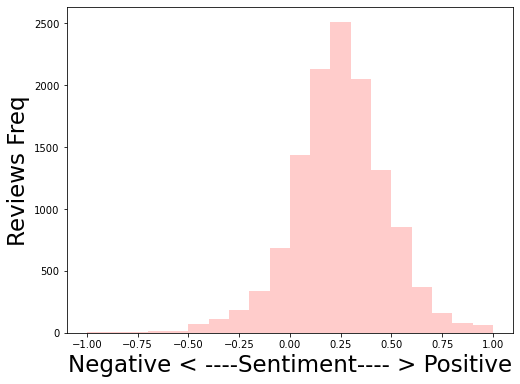

In [34]:
# pip install textblob
import pandas as pd
from textblob import TextBlob

# Assuming you have a pandas DataFrame 'df' with a column 'reviews'
# Replace 'reviews' with the name of your column containing the reviews

# Sample DataFrame structure:
# df = pd.DataFrame({'reviews': ['Great food and service!', 'Terrible experience...', 'Average at best.']})

# Function to get sentiment polarity
def get_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'reviews' column and create a new 'sentiment' column
df['sentiment'] = df['text'].apply(get_sentiment)

# df.to_csv('df_with_sentiment.csv', index=False)

import matplotlib.pyplot as plt
df['sentiment'].describe()


plt.figure(figsize=(8, 6))
plt.hist(df['sentiment'],bins=20,color='#ffcccb')

plt.xlabel('Negative < ----Sentiment---- > Positive', fontsize=23)
plt.ylabel('Reviews Freq', fontsize=23)
plt.show()

In [35]:
df

,date,Population Staying at Home,Population Not Staying at Home,Week,Month,business_id,avg_star,review_count,user_id,review_id,stars,text,name,postal_code,attributes,categories,sentiment
0,2019-01-01,510911.0,1073153.0,0,1,MMRRS6YhVRx_iN5-JhMRYg,4.0,783,Xp37UnlQCLljPwDB2u0kbw,Gtn7xLJSPbHjo0HLUT23Ow,1.0,Paid 40 bucks for bathroom issues. \n\nI had h...,Han Dynasty,19104,"{'BikeParking': 'True', 'Caters': 'True', 'Hap...","Restaurants, Chinese, Szechuan",0.126466
1,2019-01-01,510911.0,1073153.0,0,1,AGlh4ZDv6jnoiYfz7At9mw,4.0,2672,HVQKFDi-vZbawtmLMq3ZOw,-orS61f3WGoO3Cl_ovFPjQ,4.0,My boyfriend and I grabbed dinner here before ...,Dim Sum Garden,19107,"{'BikeParking': 'True', 'RestaurantsDelivery':...","Chinese, Restaurants, Dim Sum, Asian Fusion, S...",0.500000
2,2019-01-01,510911.0,1073153.0,0,1,AGlh4ZDv6jnoiYfz7At9mw,4.0,2672,3WMIo_fzJHdQ0txJx-y3aw,eUosndjvf3JJjl0EMsj_vQ,4.0,The wait is well worth it for the spicy pork s...,Dim Sum Garden,19107,"{'BikeParking': 'True', 'RestaurantsDelivery':...","Chinese, Restaurants, Dim Sum, Asian Fusion, S...",0.172487
3,2019-01-01,510911.0,1073153.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,OmL2bjLvvRxg1brM5Pehgw,myW65IT4BdTz8E028dA5dA,5.0,I can definitely walk away from here feeling l...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.242962
4,2019-01-01,510911.0,1073153.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,OMvpxF0dEIh9RUNuHPL1Uw,zQUOQIw3OOJWf4iB3PP06Q,5.0,Love this place. The service is excellent. The...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12409,2021-12-31,417009.0,1167055.0,52,12,shbtvcGnl-PEQOpffwYq-w,3.5,28,M70ofl616OAi8a7Q9pf-yw,1jShA9SOTXowJ-uFyQJbyQ,5.0,This is my mom and i's favorite place for chic...,New Panda,19152,"{'BusinessAcceptsCreditCards': 'True', 'WiFi':...","Restaurants, Japanese, Chinese",0.460000
12410,2021-12-31,417009.0,1167055.0,52,12,y7WPOc2_vCoBkwK3xPJ8XA,4.5,129,b8hCvDJX8eq2DCJLInRGWw,d6FB1Aalw-Hto03C4PfN0w,4.0,Really tasty. First time having vegetarian Chi...,Unit Su Vege,19130,"{'GoodForKids': 'True', 'HappyHour': 'False', ...","Restaurants, Chinese, Vegetarian",0.112500
12411,2021-12-31,417009.0,1167055.0,52,12,Jwp0yYMeQHdPaZZA4DQ7qQ,4.5,99,nGT9GefdIxh3NLYFZCZ0Aw,q6ZW3hZOYZvEGdtrXtoU_A,5.0,This place is a hidden gem in China Town. One ...,Chuan Kee Skewer,19107,"{'NoiseLevel': 'u'average'', 'OutdoorSeating':...","Hot Pot, Chinese, Barbeque, Restaurants",0.513333
12412,2021-12-31,417009.0,1167055.0,52,12,f-vB1_GyGBYzHX68xS5Dfw,4.0,17,CykyqrBMXHgV-2_YOq9hLA,Pi4igJeMgCv-Vvapmu3phg,5.0,Crispy calamari salad and B6-Grilled Shrimp Ve...,Saigon Quy-Bau Restaurant,19147,"{'Corkage': 'False', 'Caters': 'True', 'Outdoo...","Chinese, French, Vietnamese, Thai, American (T...",0.566667


In [28]:
df.to_csv('df_nlp.csv')

In [14]:
df_reviews=df['text']
df_reviews

0        Paid 40 bucks for bathroom issues. \n\nI had h...
1        My boyfriend and I grabbed dinner here before ...
2        The wait is well worth it for the spicy pork s...
3        I can definitely walk away from here feeling l...
4        Love this place. The service is excellent. The...
                               ...                        
12409    This is my mom and i's favorite place for chic...
12410    Really tasty. First time having vegetarian Chi...
12411    This place is a hidden gem in China Town. One ...
12412    Crispy calamari salad and B6-Grilled Shrimp Ve...
12413    Great food and environment,\nThe vermicelli is...
Name: text, Length: 12414, dtype: object

In [32]:
# pip install wordcloud
# pip install nltk

     |████████████████████████████████| 161 kB 2.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Word Cloud and Word Frequency
import pandas as pd
import nltk
# nltk.download('punkt')
import nltk
# nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re

In [16]:
# Join all the text in the 'reviews' column
all_text = ' '.join(df['text'])

# Preprocess text: convert to lowercase and remove non-alphanumeric characters
clean_text = re.sub(r'[^a-zA-Z\s]', '', all_text.lower())

# Tokenize the text
words = word_tokenize(clean_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

# Frequency analysis
word_freq = Counter(filtered_words)

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Count'])
df_word_freq
# Writing data to a CSV file using pandas
# df_word_freq.to_csv('output_word_freq.csv')

df_word_freq
# sort
sorted_df_word_freq = df_word_freq.sort_values(by='Count', ascending=False)
sorted_df_word_freq
# sorted_df_word_freq.to_csv('output_word_freq.csv')

,Count
food,10097
good,6721
place,6145
great,4565
soup,4119
...,...
taller,1
imbalanced,1
afterwish,1
reputable,1


Text(0.5, 1.0, 'Race in Philadelphia')

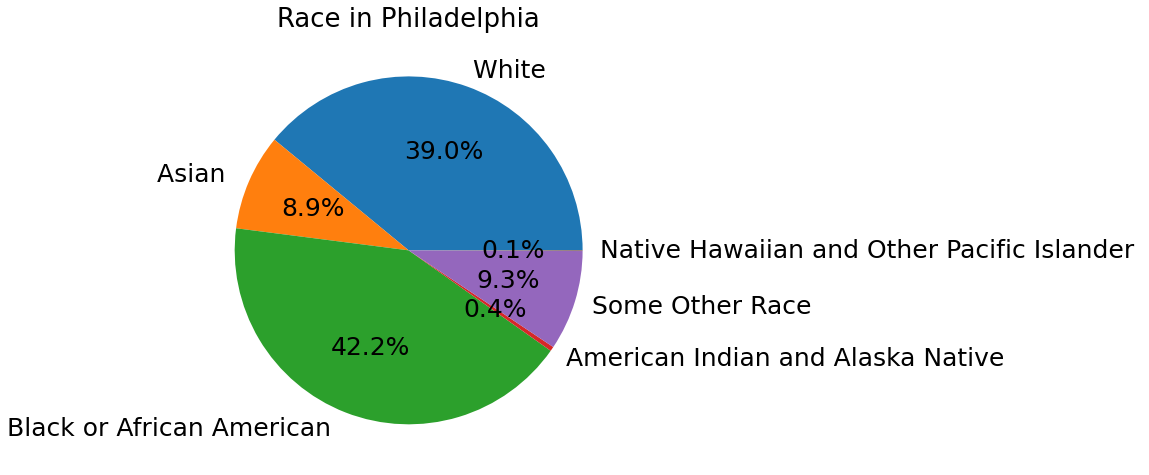

In [78]:
# Pie chart of Race in Philly
# Read the Excel file into a pandas DataFrame
df_race = pd.read_excel('race in Philly.xlsx')  # Replace 'your_file.xlsx' with your file path

plt.figure(figsize=(8, 8))
plt.pie(df_race['Number'], labels=df_race['Race'], autopct='%1.1f%%', textprops={'fontsize': 25})
plt.title('Race in Philadelphia', fontsize=26)

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

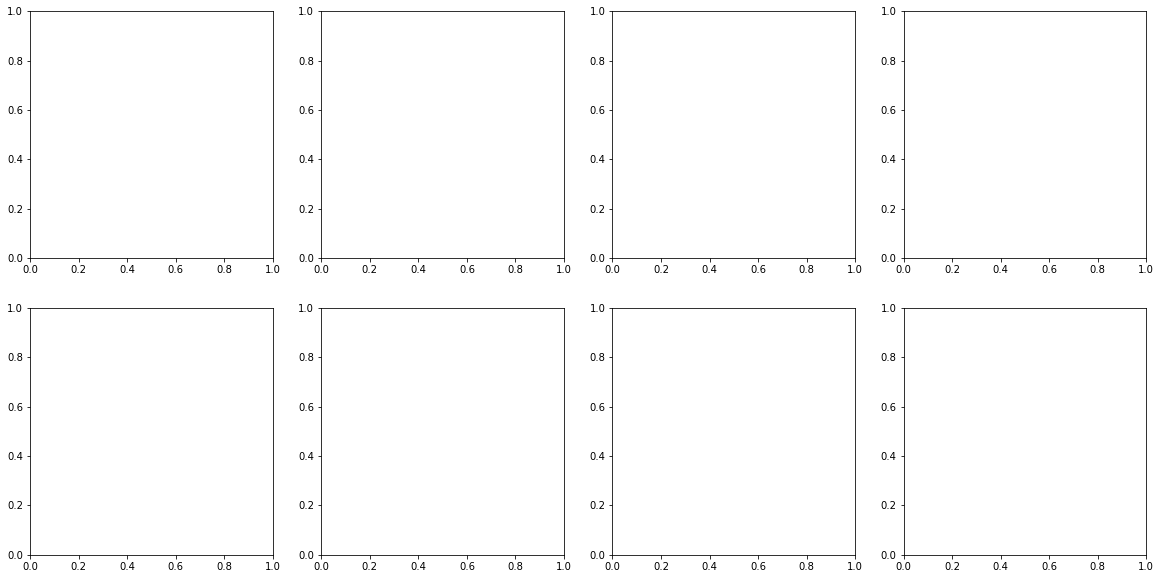

In [17]:
# word count

# Sample word list
word_list = ['chicken', 'pork', 'beef', 'lamb','duck','fish','seafood','tofu']


num_plots = len(word_list)

fig, axes = plt.subplots(2,4,  figsize=(5 * 4,10))

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=20)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Star Ratings', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Frequency', ha='center', va='center', rotation='vertical',fontsize=20)


plt.tight_layout()

plt.show()

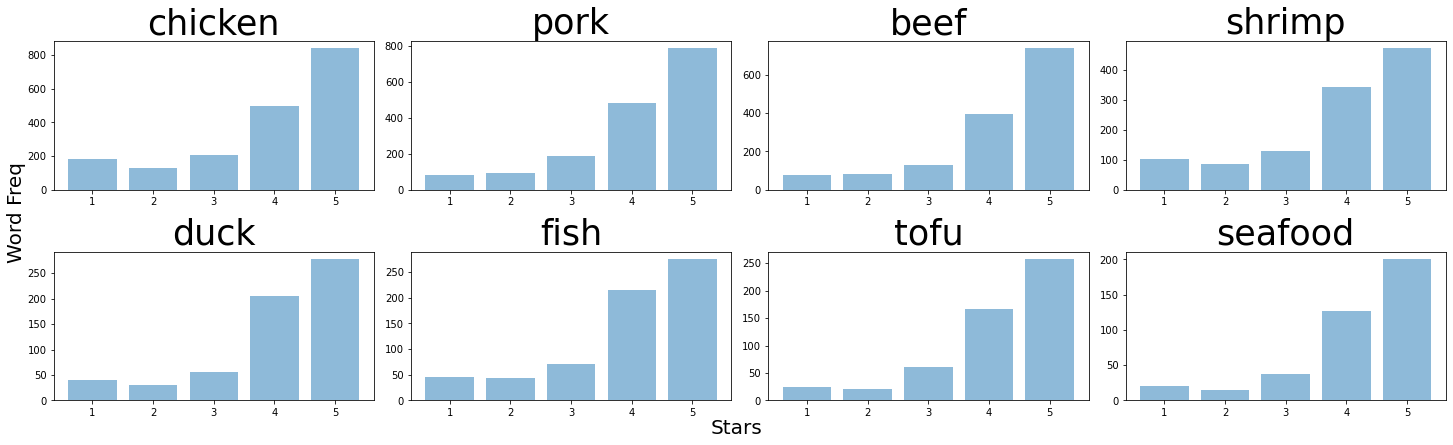

In [198]:

import matplotlib.pyplot as plt

# Sample word list
word_list = ['chicken', 'pork', 'beef', 'shrimp',  'duck', 'fish','tofu', 'seafood']

num_plots = len(word_list)

# Create a figure and subplots
fig, axes = plt.subplots(2, 4, figsize=(5 * 4, 6))

# Flatten the axes array to easily access individual subplots
axes = axes.flatten()

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=35)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Stars', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Word Freq', ha='center', va='center', rotation='vertical',fontsize=20)
plt.tight_layout()
plt.show()

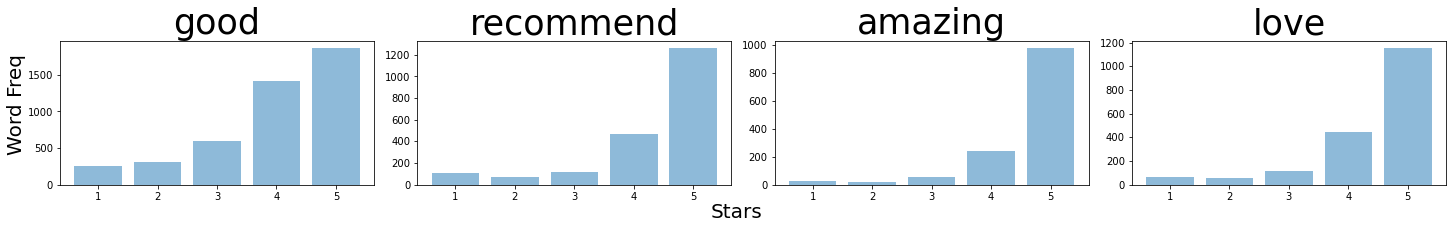

In [199]:
# word count

# Sample word list
word_list = ['good', 'recommend','amazing', 'love']


num_plots = len(word_list)

fig, axes = plt.subplots(1,num_plots,  figsize=(5 * num_plots,3))

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=35)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Stars', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Word Freq', ha='center', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()

plt.show()

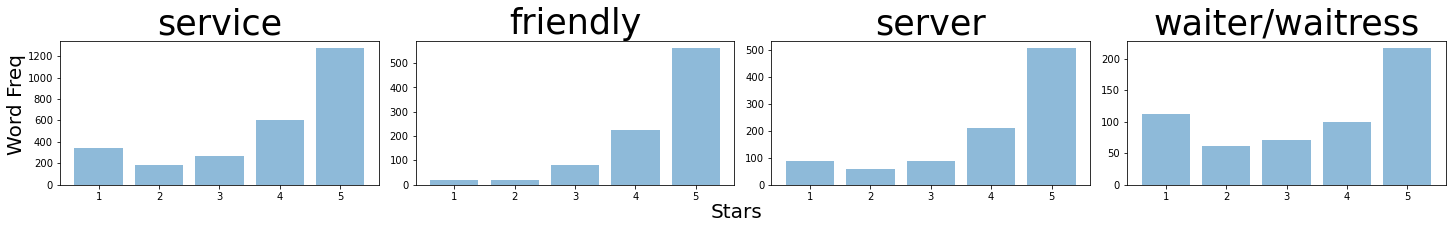

In [218]:
# word count

# Sample word list
word_list = ['service', 'friendly','server','waiter']


num_plots = len(word_list)

fig, axes = plt.subplots(1,num_plots,  figsize=(5 * num_plots,3))

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=35)
    axes[3].set_title('waiter/waitress',fontsize=35)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Stars', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Word Freq', ha='center', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()

plt.show()

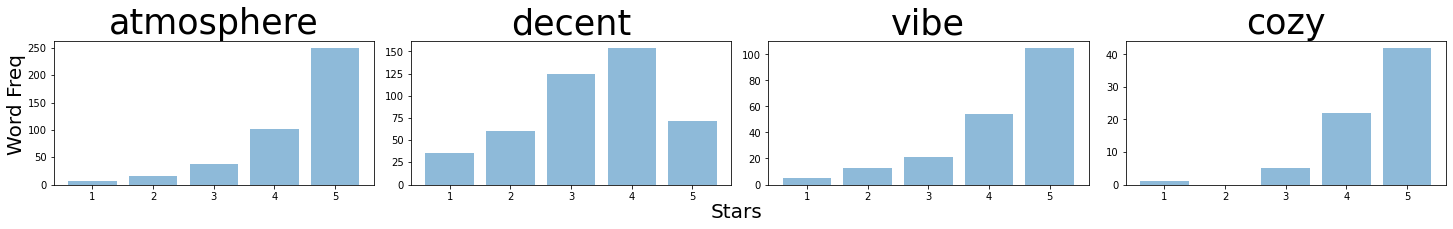

In [201]:
# atmosphere

# word count

# Sample word list
word_list = ['atmosphere','decent','vibe','cozy']


num_plots = len(word_list)

fig, axes = plt.subplots(1,num_plots,  figsize=(5 * num_plots,3))

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=35)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Stars', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Word Freq', ha='center', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()

plt.show()

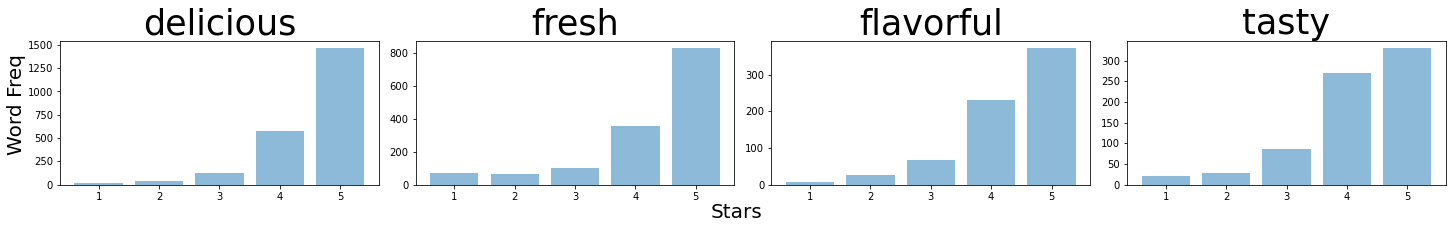

In [202]:
# word count

# Sample word list
word_list = ['delicious', 'fresh','flavorful', 'tasty']


num_plots = len(word_list)

fig, axes = plt.subplots(1,num_plots,  figsize=(5 * num_plots,3))

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=35)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Stars', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Word Freq', ha='center', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()

plt.show()

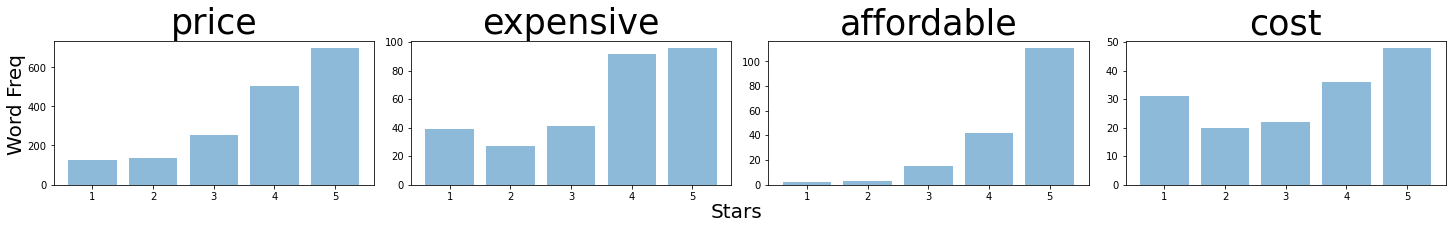

In [207]:
# word count

# Sample word list
word_list = ['price', 'expensive','affordable','cost']


num_plots = len(word_list)

fig, axes = plt.subplots(1,num_plots,  figsize=(5 * num_plots,3))

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=35)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Stars', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Word Freq', ha='center', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()

plt.show()

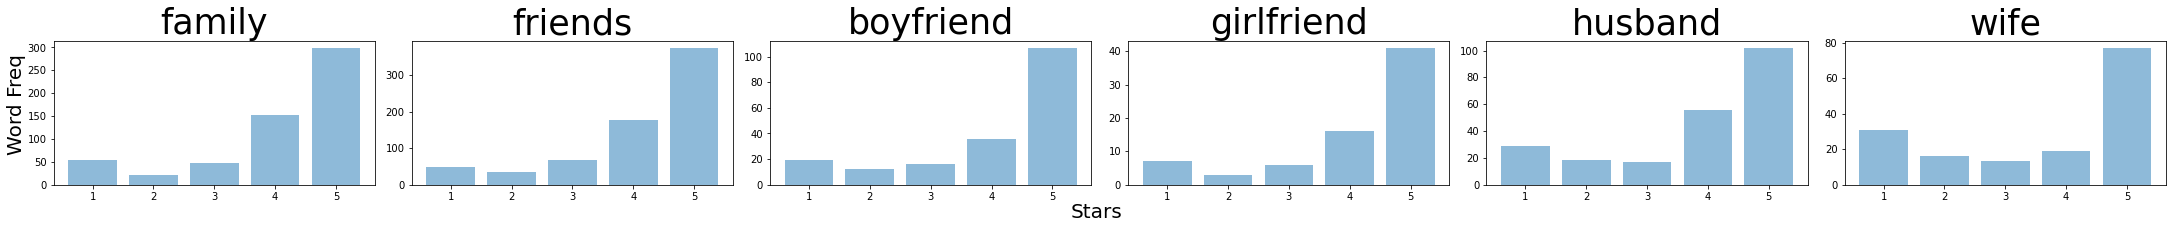

In [204]:
# families
# Sample word list
word_list = ['family', 'friends','boyfriend','girlfriend','husband','wife']


num_plots = len(word_list)

fig, axes = plt.subplots(1,num_plots,  figsize=(5 * num_plots,3))

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=35)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Stars', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Word Freq', ha='center', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()

plt.show()

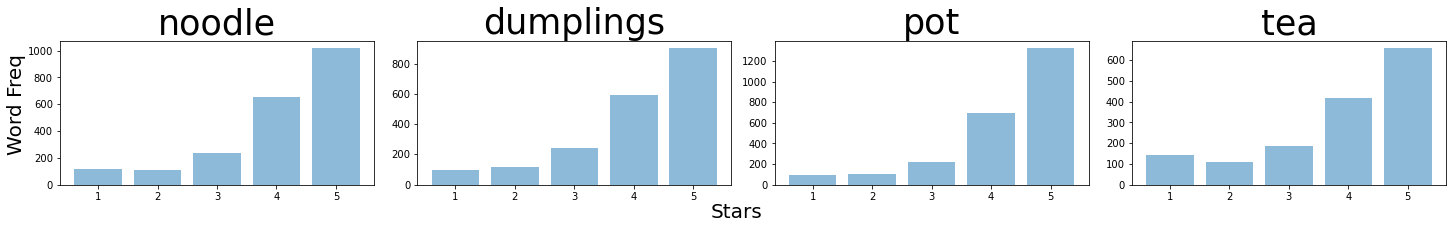

In [205]:
# noodle hotpot
# Sample word list
word_list = ['noodle', 'dumplings','pot','tea']


num_plots = len(word_list)

fig, axes = plt.subplots(1,num_plots,  figsize=(5 * num_plots,3))

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=35)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Stars', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Word Freq', ha='center', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()

plt.show()

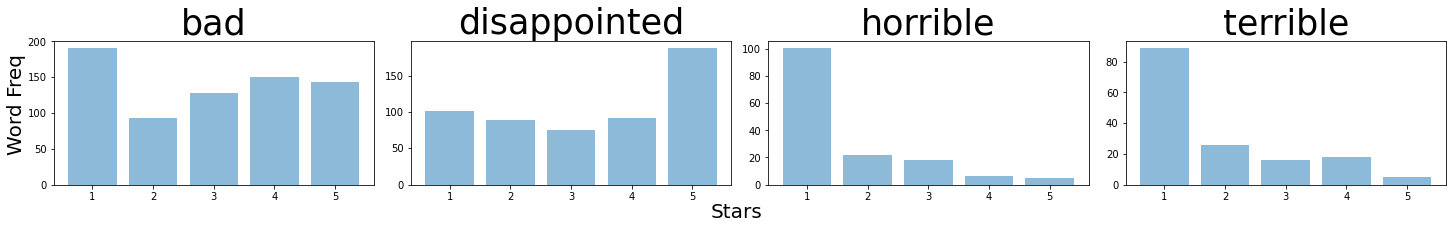

In [206]:
# disappointed
# Sample word list
word_list = ['bad', 'disappointed','horrible','terrible']


num_plots = len(word_list)

fig, axes = plt.subplots(1,num_plots,  figsize=(5 * num_plots,3))

# Create the plots for each word
for i, word in enumerate(word_list):
    df[word] = df['text'].apply(lambda review: 1 if word in review else 0)
    counts = df[df[word] == 1]['stars'].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, align='center', alpha=0.5)
    axes[i].set_title(f'{word}',fontsize=35)
    # axes[i].set_xticks(counts.index) 
    # Ensure all star ratings are displayed on the x-axis

fig.text(0.5, 0, 'Stars', ha='center', va='center',fontsize=20)
fig.text(0, 0.5, 'Word Freq', ha='center', va='center', rotation='vertical',fontsize=20)
plt.tight_layout()

plt.show()

In [222]:
len(df['text'])

12414

In [ ]:
# piechart of meat/dishes

In [18]:
df_word_freq['text']=df_word_freq.index
df_word_freq


,Count,text
paid,169,paid
bucks,47,bucks
bathroom,94,bathroom
issues,68,issues
heard,160,heard
...,...,...
beefscallion,1,beefscallion
tastelessnot,1,tastelessnot
sammy,1,sammy
reaaallly,1,reaaallly


         Count      tex     text
pork      2750     pork     pork
tofu       881     tofu     tofu
chicken   3286  chicken  chicken
seafood   3785  seafood  seafood
beef      2343     beef     beef
duck      1241     duck     duck


/Users/wanxintu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(-1.109323824043253,
 1.100443993855221,
 -1.1010484385897843,
 1.1014628640927295)

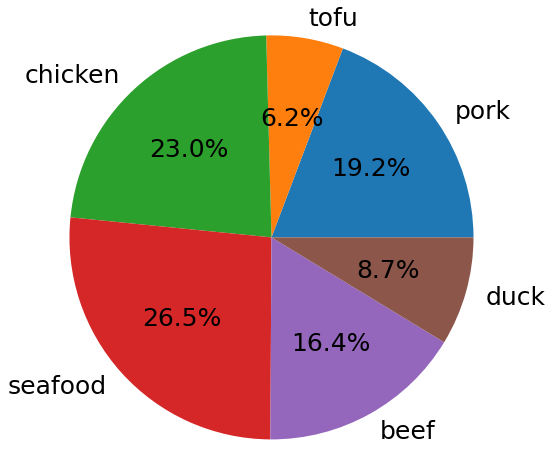

In [252]:
food_list= ['chicken', 'pork', 'beef', 'shrimp',  'duck', 'fish','tofu', 'seafood','crab']
filtered_df = df_word_freq[df_word_freq['text'].isin(food_list)]

condition = filtered_df['text'] == 'seafood'
filtered_df.loc[condition, 'Count'] = 564+855+461+1905
#delete noodle

filtered_df=filtered_df[filtered_df['text'] != 'fish']
filtered_df=filtered_df[filtered_df['text'] != 'shrimp']
filtered_df=filtered_df[filtered_df['text'] != 'crab']
print(filtered_df)
plt.figure(figsize=(8, 8))
plt.pie(filtered_df['Count'], labels=filtered_df['text'], autopct='%1.1f%%', textprops={'fontsize': 25})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


           Count        tex       text
rice        2657       rice       rice
dumplings   3463  dumplings  dumplings
scallion     683   scallion   scallion
soup        4119       soup       soup
broth       1175      broth      broth
noodles     3030    noodles    noodles
dim         1663        dim        dim
rolls        763      rolls      rolls
egg          731        egg        egg
sushi        639      sushi      sushi
pho          230        pho        pho


/Users/wanxintu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(-1.1267273080950344,
 1.1012727289569064,
 -1.1117024447108492,
 1.1176729000002483)

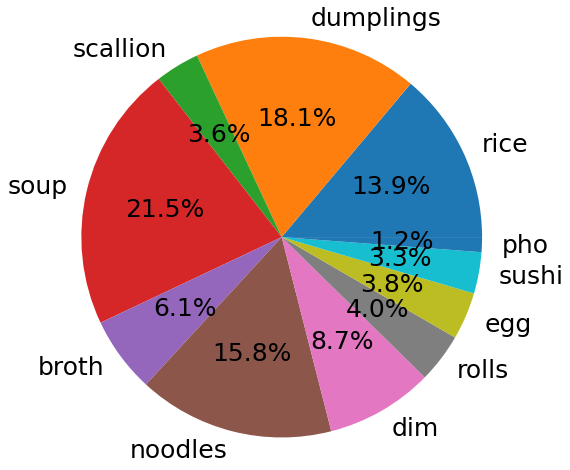

In [253]:
food_list= [
'soup','dumplings','noodles','rice','dim','noodle','broth','pho','scallion','egg','rolls','sushi']
filtered_df = df_word_freq[df_word_freq['text'].isin(food_list)]
condition = filtered_df['text'] == 'noodles'
filtered_df.loc[condition, 'Count'] = 1663 + 1367
#delete noodle

filtered_df=filtered_df[filtered_df['text'] != 'noodle']
                        
print(filtered_df)
plt.figure(figsize=(8, 8))
plt.pie(filtered_df['Count'], labels=filtered_df['text'], autopct='%1.1f%%', textprops={'fontsize': 25})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


            Count         tex        text
boyfriend     229   boyfriend   boyfriend
husband       250     husband     husband
family        624      family      family
friend       1431      friend      friend
wife          219        wife        wife
girlfriend     75  girlfriend  girlfriend


/Users/wanxintu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(-1.1088101620987758,
 1.100419532209622,
 -1.1104833199939328,
 1.1276673360474005)

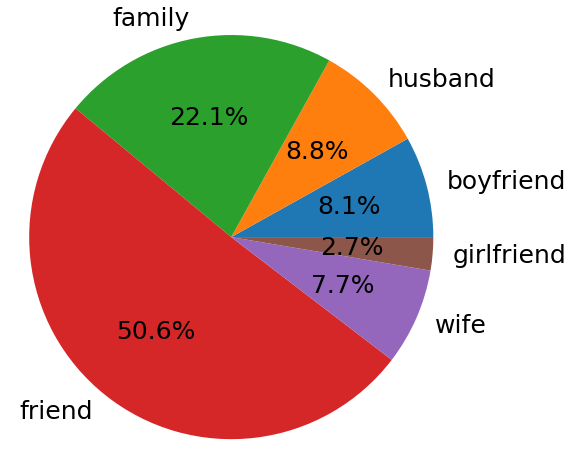

In [258]:
food_list= [
'family','friend','friends','girlfriend','boyfriend','wife','husband']
filtered_df = df_word_freq[df_word_freq['text'].isin(food_list)]


condition = filtered_df['text'] == 'friend'
filtered_df.loc[condition, 'Count'] = 814+617
#delete noodle
filtered_df=filtered_df[filtered_df['text'] != 'friends']
       

print(filtered_df)
plt.figure(figsize=(8, 8))
plt.pie(filtered_df['Count'], labels=filtered_df['text'], autopct='%1.1f%%', textprops={'fontsize': 25})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


In [23]:
df

,date,Population Staying at Home,Population Not Staying at Home,Week,Month,business_id,avg_star,review_count,user_id,review_id,stars,text,name,postal_code,attributes,categories,sentiment
0,2019-01-01,510911.0,1073153.0,0,1,MMRRS6YhVRx_iN5-JhMRYg,4.0,783,Xp37UnlQCLljPwDB2u0kbw,Gtn7xLJSPbHjo0HLUT23Ow,1.0,Paid 40 bucks for bathroom issues. \n\nI had h...,Han Dynasty,19104,"{'BikeParking': 'True', 'Caters': 'True', 'Hap...","Restaurants, Chinese, Szechuan",0.126466
1,2019-01-01,510911.0,1073153.0,0,1,AGlh4ZDv6jnoiYfz7At9mw,4.0,2672,HVQKFDi-vZbawtmLMq3ZOw,-orS61f3WGoO3Cl_ovFPjQ,4.0,My boyfriend and I grabbed dinner here before ...,Dim Sum Garden,19107,"{'BikeParking': 'True', 'RestaurantsDelivery':...","Chinese, Restaurants, Dim Sum, Asian Fusion, S...",0.500000
2,2019-01-01,510911.0,1073153.0,0,1,AGlh4ZDv6jnoiYfz7At9mw,4.0,2672,3WMIo_fzJHdQ0txJx-y3aw,eUosndjvf3JJjl0EMsj_vQ,4.0,The wait is well worth it for the spicy pork s...,Dim Sum Garden,19107,"{'BikeParking': 'True', 'RestaurantsDelivery':...","Chinese, Restaurants, Dim Sum, Asian Fusion, S...",0.172487
3,2019-01-01,510911.0,1073153.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,OmL2bjLvvRxg1brM5Pehgw,myW65IT4BdTz8E028dA5dA,5.0,I can definitely walk away from here feeling l...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.242962
4,2019-01-01,510911.0,1073153.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,OMvpxF0dEIh9RUNuHPL1Uw,zQUOQIw3OOJWf4iB3PP06Q,5.0,Love this place. The service is excellent. The...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12409,2021-12-31,417009.0,1167055.0,52,12,shbtvcGnl-PEQOpffwYq-w,3.5,28,M70ofl616OAi8a7Q9pf-yw,1jShA9SOTXowJ-uFyQJbyQ,5.0,This is my mom and i's favorite place for chic...,New Panda,19152,"{'BusinessAcceptsCreditCards': 'True', 'WiFi':...","Restaurants, Japanese, Chinese",0.460000
12410,2021-12-31,417009.0,1167055.0,52,12,y7WPOc2_vCoBkwK3xPJ8XA,4.5,129,b8hCvDJX8eq2DCJLInRGWw,d6FB1Aalw-Hto03C4PfN0w,4.0,Really tasty. First time having vegetarian Chi...,Unit Su Vege,19130,"{'GoodForKids': 'True', 'HappyHour': 'False', ...","Restaurants, Chinese, Vegetarian",0.112500
12411,2021-12-31,417009.0,1167055.0,52,12,Jwp0yYMeQHdPaZZA4DQ7qQ,4.5,99,nGT9GefdIxh3NLYFZCZ0Aw,q6ZW3hZOYZvEGdtrXtoU_A,5.0,This place is a hidden gem in China Town. One ...,Chuan Kee Skewer,19107,"{'NoiseLevel': 'u'average'', 'OutdoorSeating':...","Hot Pot, Chinese, Barbeque, Restaurants",0.513333
12412,2021-12-31,417009.0,1167055.0,52,12,f-vB1_GyGBYzHX68xS5Dfw,4.0,17,CykyqrBMXHgV-2_YOq9hLA,Pi4igJeMgCv-Vvapmu3phg,5.0,Crispy calamari salad and B6-Grilled Shrimp Ve...,Saigon Quy-Bau Restaurant,19147,"{'Corkage': 'False', 'Caters': 'True', 'Outdoo...","Chinese, French, Vietnamese, Thai, American (T...",0.566667


In [24]:
# find a business example
df

from collections import Counter

# Sample list
df_id =df['business_id']

# Use Counter to count the frequency of each element
frequency_counter = Counter(df_id)

# Print the result
print(frequency_counter)

Counter({'iksVwRfpWymIUUFqw0tXpw': 979, 'ytynqOUb3hjKeJfRj5Tshw': 959, 'AGlh4ZDv6jnoiYfz7At9mw': 729, 'kZ1q0K13tFYG_ZJrVvsJHA': 471, 'ntiIq1FNqduOyyowMFGh5A': 399, 'kbXpjBSweedxQ1WrlJ5i7Q': 282, 'nIAbuktMEzVjT4P9pG89rQ': 251, 'eaDZlSuVS0EY67Ke6pRP6Q': 236, 'qY-BUQY-SFBaSrFHowF3nA': 220, 'UQZ4p6xb_7gY7UXHmBzceg': 191, 'hUmHwBQtGg0iH-PZakQJDw': 187, '_V6hl1oGkTV2KbGeax_HPA': 176, 'SADPX8WX34EQDj_jqtacMw': 169, 'MMRRS6YhVRx_iN5-JhMRYg': 161, 'qISf5ojuYbD9h71NumGUQA': 161, 'QhgrhVKlXZtSY6gRThf8zA': 160, 'VP8HMhVt-pKmqGNmDW4-TQ': 159, 'Ep_jh1Pt4Ggyla21f-BQcQ': 140, 'zU5PPd9j4bYC_MepNSEDcA': 137, 'POuaebsAeCyNx-8qZ3O7XQ': 130, 'y7WPOc2_vCoBkwK3xPJ8XA': 130, '0S3TvsmbCeOZ9UitnpRd1A': 107, '-1B9pP_CrRBJYPICE5WbRA': 106, 'oyA87-Q_vqnmxVOn_auJQQ': 106, 'gjFUrbSMo1rA1jgG5IhA2A': 100, 'Jwp0yYMeQHdPaZZA4DQ7qQ': 98, 's9ceDy-cVHe0uzvZpWq87Q': 97, 'NEZOlUKoQWUotatzRp-r5A': 92, '838bEDzZSPveDkAGrhVWYQ': 91, '7z16CBc74GhbyqalwZrJUQ': 91, 'uIlFxzyoJy7ud9j12aK7MA': 91, 'FIFi_8eNmc-jPHZVHPS3NQ': 90, 'UPD4q

In [25]:
df_rest1=df[df['business_id']=='iksVwRfpWymIUUFqw0tXpw']

In [26]:
df_rest1

,date,Population Staying at Home,Population Not Staying at Home,Week,Month,business_id,avg_star,review_count,user_id,review_id,stars,text,name,postal_code,attributes,categories,sentiment
3,2019-01-01,510911.0,1073153.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,OmL2bjLvvRxg1brM5Pehgw,myW65IT4BdTz8E028dA5dA,5.0,I can definitely walk away from here feeling l...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.242962
4,2019-01-01,510911.0,1073153.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,OMvpxF0dEIh9RUNuHPL1Uw,zQUOQIw3OOJWf4iB3PP06Q,5.0,Love this place. The service is excellent. The...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.550000
5,2019-01-01,510911.0,1073153.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,aLXnLxLvuxjxyGlJ8c2i5A,qjRROaX9YjMfeUkCBxGnXg,5.0,"Great food, tried the tomatoe base, spicy base...",Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.168615
17,2019-01-02,403677.0,1180387.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,ozLdJ0xVj14_EEItLgD4sg,M7av7ptRWJ_nTikUGeVpMg,5.0,超级好吃的一家店环境也好服务的小姐姐们都超级nice，Simin小姐姐超级好~非常热情可爱。...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.000000
18,2019-01-02,403677.0,1180387.0,0,1,iksVwRfpWymIUUFqw0tXpw,4.5,1128,gSIew_4a7e_NPp1lTT92_g,MCmiuyzatVXLLtHvf_GsyQ,5.0,THIS IS THE BEST HOTPOT I'VE HAD. The menu / c...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.251225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12310,2021-12-23,418500.0,1165564.0,51,12,iksVwRfpWymIUUFqw0tXpw,4.5,1128,zk7sLN4ld4v6_aUb1WL9Cg,a9eyDRx2RBUlHv2zcB-sOg,2.0,I think the only word I could use to describe ...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.181326
12381,2021-12-29,409792.0,1174272.0,52,12,iksVwRfpWymIUUFqw0tXpw,4.5,1128,XkWNxsOZ4J9Ti3BdIvfuvA,XDFtF_JxzTqDU04jnQ6lWg,4.0,Our first time here was nice with good food an...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.385833
12395,2021-12-30,406586.0,1177478.0,52,12,iksVwRfpWymIUUFqw0tXpw,4.5,1128,tJgQm4i2MlIpk5TZaQFrfw,mPbDHfXSa706vOEiIMutRg,1.0,Ordered take our. Took forever and they never ...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",-0.081944
12396,2021-12-30,406586.0,1177478.0,52,12,iksVwRfpWymIUUFqw0tXpw,4.5,1128,Kh5bz_p3luJkjFLzr_haSg,Z1SgNsYoONlVbIxjqJUfcQ,5.0,The service was really quick and all of the fo...,Chubby Cattle,19107,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...",0.502292


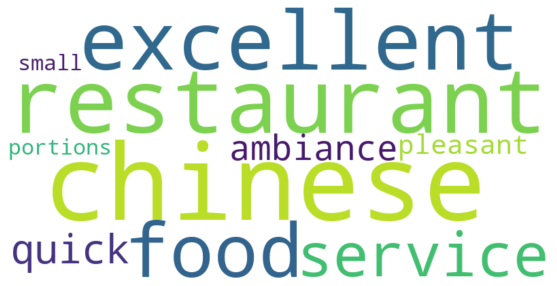

In [55]:
# pip install wordcloud + sentiment
# wordcloud
from wordcloud import WordCloud

# Sample text
text_combined = ' '.join(df_rest1['text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

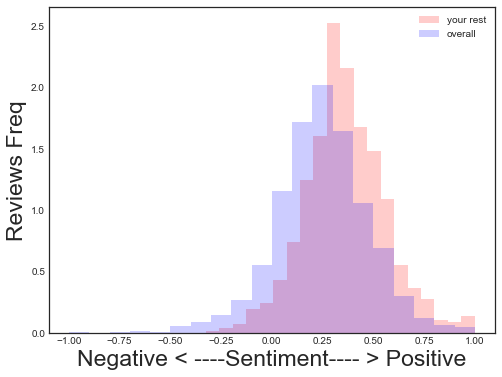

In [67]:

# df.to_csv('df_with_sentiment.csv', index=False)

import matplotlib.pyplot as plt

plt.style.use('seaborn-white')

df_rest1['sentiment'].describe()


plt.figure(figsize=(8, 6))

plt.hist(df_rest1['sentiment'],bins=20,color='#ffcccb', density=True,label='your rest')
plt.hist(df['sentiment'],bins=20,color='blue',alpha=0.2, density=True,label='overall')
plt.legend(loc='upper right')
plt.xlabel('Negative < ----Sentiment---- > Positive', fontsize=23)
plt.ylabel('Reviews Freq', fontsize=23)
plt.show()

In [56]:
# Preprocess text: convert to lowercase and remove non-alphanumeric characters
clean_text = re.sub(r'[^a-zA-Z\s]', '', text_combined.lower())

# Tokenize the text
words = word_tokenize(clean_text)

# Remove stopwords
# stop_words = set(stopwords.words('english'))
# Define a list of new stopwords
new_stopwords = ['food', 'chinese', 'place','time','really','definitely','also','first','would','get','like','everything']

positive_word=['good','great','amazing','recommend','best']

service_word=['service','server']

# Extend the existing set of English stopwords with the new stopwords
stop_words =set(stopwords.words('english'))
stop_words.update(new_stopwords)


filtered_words = [word for word in words if word not in stop_words]

# Frequency analysis
word_freq = Counter(filtered_words)

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Count'])
df_word_freq
# Writing data to a CSV file using pandas
# df_word_freq.to_csv('output_word_freq.csv')

df_word_freq
# sort
sorted_df_word_freq = df_word_freq.sort_values(by='Count', ascending=False)
sorted_df_word_freq
sorted_df_word_freq.to_csv('output_word_freq_rest1.csv')

In [41]:
new_stopwords = ['food', 'chinese', 'place']

# Extend the existing set of English stopwords with the new stopwords
stop_words =set(stopwords.words('english'))
stop_words.update(new_stopwords)


In [46]:
df_rest1['text'] = df_rest1['text'].str.lower()

# Use str.contains() to filter rows containing 'hot pot'
filtered_rows = df_rest1[df_rest1['text'].str.contains('hot pot')]

# Get the count of rows with 'hot pot'
phrase_freq = len(filtered_rows)

print("Frequency of 'hot pot':", phrase_freq)
# print("Frequency of 'hot pot':", word_freq.get('hot pot', 0))

Frequency of 'hot pot': 379


/var/folders/_3/zw8zwjmd1sd8mp006b2mw13c0000gn/T/ipykernel_47879/1154705786.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rest1['text'] = df_rest1['text'].str.lower()


In [48]:
restaurants_df[restaurants_df['business_id']=='iksVwRfpWymIUUFqw0tXpw']

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,attributes,categories,hours
396,iksVwRfpWymIUUFqw0tXpw,Chubby Cattle,146 N 10th St,Philadelphia,PA,19107,39.95501,-75.156134,4.5,1128,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Bars, Seafood, Japanese, Hot Pot,...","{'Monday': '0:0-0:0', 'Tuesday': '17:0-22:0', ..."


In [54]:
from shiny import App, ui

# Part 1: ui ----
app_ui = ui.page_fluid(
    "Hello, world!",
)

# Part 2: server ----
def server(input, output, session):
    ...

# Combine into a shiny app.
# Note that the variable must be "app".
app = App(app_ui, server)

ImportError: cannot import name 'NotRequired' from 'typing_extensions' (/Users/wanxintu/opt/anaconda3/lib/python3.9/site-packages/typing_extensions.py)